In [3]:
import PyPDF2
import spacy
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import csv
%matplotlib inline

In [4]:
pdf= PyPDF2.PdfFileReader("Informe_Gobierno_de_Mexico.pdf")

full_text= ""

The page numbers in the PDF are not the same as the reported number of pages, we use this variable to keep track of both.

In [5]:
pdf_pg_number= 3 

We will only retrieve the first 3 sections of the government report which are between pages 14 and 326. The reason for this is that only the 3 first sections contain a substantial amount of text.

In [6]:
# This block is used to remove the page numbers 
for i in range(14, 327):
    if pdf_pg_number <= 9:
        page_text = pdf.getPage(i).extractText().strip()[1:]
        
    elif pdf_pg_number >= 10 and pdf_pg_number <= 99:
        page_text = pdf.getPage(i).extractText().strip()[2:]
        
    else:
        page_text = pdf.getPage(i).extractText().strip()[3:]

    full_text += page_text.replace("\n", "")
    pdf_pg_number += 1
    

The previous code block ensures that the output is the cleanest as possible. It removes page numbers and builds us the full transcript to a single string.

Next below,I manually fix all the weird characters with their correct equivalents.

In [7]:
CHARACTERS = {"ç": "Á",
              "⁄": "á",
              "…": "É",
              "”": "é",
              "ê": "Í",
              "™": 'í',
              "î": "Ó"}

for item, replacement in CHARACTERS.items():
    full_text= full_text.replace(item, replacement)

In [8]:
# Remove all extra white spaces and finally we save the cleaned text into a .txt file.
full_text = full_text.replace("  ", " ").replace("  ", " ").replace("  ", " ")

with open("transcript_clean.txt", "w", encoding="utf-8") as temp_file:
    temp_file.write(full_text)

Installed the Spanish Model (`es_core_news_md`) and start preparing the corpus with the loaded Spanish Model

In [9]:
import es_core_news_md
nlp = es_core_news_md.load()

corpus = open("transcript_clean.txt", "r", encoding="utf-8").read()


# Corpus is bigger than the default limit, thus a new limit is set equal to its length.

nlp.max_length = len(corpus)

doc = nlp(corpus)

## Text Tokens

The code below is pretty straight forward. 

First I intialize a list with a header row. Then, I iterate over the document, which in this case is the `doc` object, and add the following tokens to the data list and save it to csv using `csv.writer()`:
* text
* lemma
* part-of-speech
* other properties 

In [18]:
data_list = [["text", "text_lower", "lemma", "lemma_lower",
                "part_of_speech", "is_alphabet", "is_stopword"]]

for token in doc:
    data_list.append([token.text, token.lower_, token.lemma_, token.lemma_.lower(), token.pos_, token.is_alpha, 
                      token.is_stop])

csv.writer(open("./tokens.csv", "w", encoding="utf-8", newline="")).writerows(data_list)

It is important to note that a token is not always a word, it can be a punctuation mark or a number. That's why the `is_alpha` property is saved so that I can later filter out non-alphabetic tokens.

I also saved the lowercase form of all tokens and lemmas so I don't have to do it every time we want to process them with pandas.

## Text Entities

This is almost the same as the previous code block, the main difference is that we iterate over the `doc.ents` object. Entities refer to real world persons, organizations or locations. Since the model was trained from `Wikipedia` I will get a broad amount of them.

In [19]:
data_list = [["text", "text_lower", "label"]]

for ent in doc.ents:
    data_list.append([ent.text, ent.lower_, ent.label_])

csv.writer(open("./entities.csv", "w", encoding="utf-8", newline="")).writerows(data_list)

## Text Sentences

This function is a bit different than the previous ones, in this part I counted the number of positive and negative words per sentence.

I used the following dataset of positive and negative words from [Sentiment Lexicons for 81 Languages](https://www.kaggle.com/rtatman/sentiment-lexicons-for-81-languages):
* `negative_words_es.txt`
* `positive_words_es.txt`

In [20]:
with open("positive_words_es.txt", "r", encoding="utf-8") as temp_file:
    positive_words = temp_file.read().splitlines()

with open("negative_words_es.txt", "r", encoding="utf-8") as temp_file:
    negative_words = temp_file.read().splitlines()

Now I iterate over the doc.sents object and keep a score for each sentence and save the results to csv, which can be analyzed with `pandas` and plotted with `matplotlib` :

In [21]:
data_list = [["text", "score"]]

for sent in doc.sents:

    # Only take into account real sentences.
    if len(sent.text) > 10:

        score = 0

        # Start scoring the sentence.
        for word in sent:

            if word.lower_ in positive_words:
                score += 1

            if word.lower_ in negative_words:
                score -= 1

        data_list.append([sent.text, score])

csv.writer(open("./sentences.csv", "w", encoding="utf-8",
                newline="")).writerows(data_list)

***

## Visualizing The Data

#### Plotting Horizontal Bar Graph of Most Frequent Words

In [22]:
# Start by loading the tokens csv file into a DataFrame
df= pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Capstone Project\Main Capstone Project Two\tokens.csv")

In [23]:
df.head()

,text,text_lower,lemma,lemma_lower,part_of_speech,is_alphabet,is_stopword
0,1,1,1,1,NUM,False,False
1,.,.,.,.,PUNCT,False,False
2,POLÍTICA,política,POLÍTICA,política,NOUN,True,False
3,Y,y,Y,y,CONJ,True,False
4,GOBIERNO,gobierno,GOBIERNO,gobierno,PROPN,True,False


In [24]:
# Grouping together "programa" and "programar"
df.loc[df["lemma_lower"] == "programa", "lemma_lower"] = "programar"

In [25]:
# Considering the top 20 alphabets tokens that are longer than 1 character and are not stop words

words = df[(df["is_alphabet"] == True) & (df["is_stopword"] == False) & (
    df["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()[:20]

In [26]:
sns.set(style="ticks",
    rc={"figure.figsize": [14, 9],
        "text.color": "black",
        "axes.labelcolor": "black",
        "axes.edgecolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.facecolor": "white",
        "figure.facecolor": "white"})

Text(0.5, 1.0, 'Most Frequent Words')

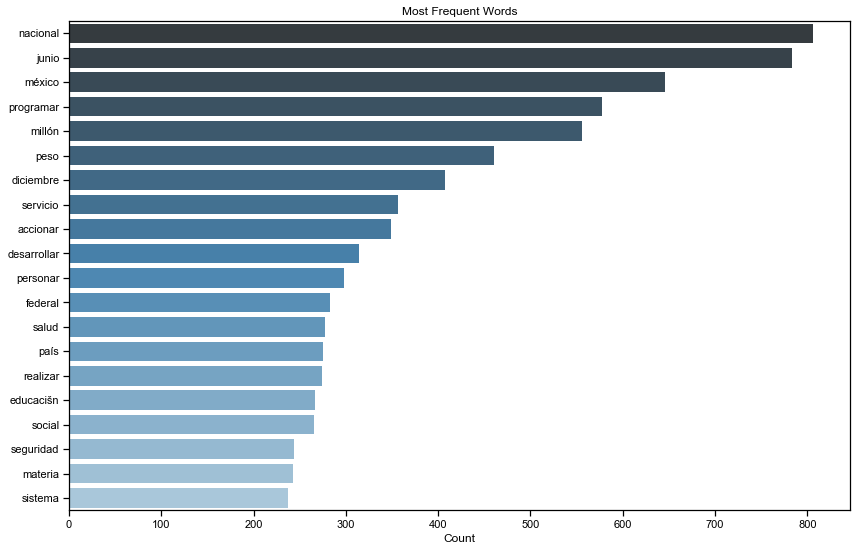

In [27]:
# Use seaborn barplot to visiulize the most frequent words
sns.barplot(x=words.values, y=words.index, palette="Blues_d", linewidth=0)
plt.xlabel("Count")
plt.title("Most Frequent Words")


#### Plotting Mentions per Mexican State

In [28]:
df_e= pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Capstone Project\Main Capstone Project Two\entities.csv")
mexico_df= geopandas.read_file(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Capstone Project\Main Capstone Project Two\mexstates")

In [29]:
df_e.head()

,text,text_lower,label
0,1,1,LOC
1,Y GOBIERNO La Cuarta TransformaciŠn,y gobierno la cuarta transformacišn,LOC
2,Ejecutivo Federal,ejecutivo federal,LOC
3,Gobierno Federal,gobierno federal,LOC
4,Šrdenes,šrdenes,PER


In [42]:
mexico_df

,OBJECTID,FIPS_ADMIN,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,GMI_CNTRY,CNTRY_NAME,POP_ADMIN,TYPE_ENG,TYPE_LOC,SQKM,SQMI,COLOR_MAP,Shape_Leng,Shape_Area,geometry,count
0,888,MX06,MEX-CHH,Chihuahua,MX,MEX,Mexico,2656214,State,Estado,247935.02,95727.70,12,22.609277,22.890985,"POLYGON ((-103.63086 26.66108, -103.66501 26.6...",49.0
1,933,MX07,MEX-CDZ,Coahuila,MX,MEX,Mexico,2145539,State,Estado,150843.95,58240.87,2,18.993090,13.733655,"POLYGON ((-102.66695 25.07583, -102.71890 24.9...",36.0
2,976,MX19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,"POLYGON ((-99.71390 27.66894, -99.85918 27.563...",0.0
3,978,MX28,MEX-TML,Tamaulipas,MX,MEX,Mexico,2272724,State,Estado,79502.24,30695.81,11,18.023144,7.056563,"POLYGON ((-98.61609 22.41849, -98.63028 22.422...",36.0
4,998,MX25,MEX-SIN,Sinaloa,MX,MEX,Mexico,2397706,State,Estado,57638.85,22254.36,5,16.466051,5.145524,"POLYGON ((-108.39418 25.14111, -108.39251 25.2...",43.0
5,1004,MX10,MEX-DRN,Durango,MX,MEX,Mexico,1467826,State,Estado,120674.60,46592.46,4,17.512895,10.764853,"POLYGON ((-104.31143 22.31921, -104.31390 22.3...",40.0
6,1026,MX32,MEX-ZCT,Zacatecas,MX,MEX,Mexico,1383680,State,Estado,74995.58,28955.79,7,19.712770,6.605460,"POLYGON ((-101.52486 21.85664, -101.54224 21.8...",29.0
7,1034,MX24,MEX-SLP,San Luis Potosi,MX,MEX,Mexico,2179006,State,Estado,64140.09,24764.49,1,13.951424,5.620107,"POLYGON ((-98.51501 21.39889, -98.52653 21.398...",34.0
8,1051,MX14,MEX-JLS,Jalisco,MX,MEX,Mexico,5772704,State,Estado,79851.44,30830.64,8,20.993489,6.900025,"POLYGON ((-104.59242 19.14794, -104.67590 19.1...",46.0
9,1057,MX01,MEX-AGS,Aguascalientes,MX,MEX,Mexico,782890,State,Estado,5609.14,2165.69,4,2.807425,0.489324,"POLYGON ((-101.84621 22.01176, -101.87140 21.9...",18.0


In [30]:
STATES = ["Aguascalientes",
    "Baja California",
    "Baja California Sur",
    "Campeche",
    "Chiapas",
    "Chihuahua",
    "Ciudad de México",
    "Coahuila",
    "Colima",
    "Durango",
    "Estado de México",
    "Guanajuato",
    "Guerrero",
    "Hidalgo",
    "Jalisco",
    "Michoacán",
    "Morelos",
    "Nayarit",
    "Nuevo León",
    "Oaxaca",
    "Puebla",
    "Querétaro",
    "Quintana Roo",
    "San Luis Potosí",
    "Sinaloa",
    "Sonora",
    "Tabasco",
    "Tamaulipas",
    "Tlaxcala",
    "Veracruz",
    "Yucatán",
    "Zacatecas"]

In [31]:
def get_entity_counts(df):
    
    entities=df["label"].value_counts()
    print(entities)
    
    locations=df[df["label"]=="ORG"]["text"].value_counts()
    print(locations)
    

In [32]:
def get_state_counts(df):
    
    total_count=0
    state_counts= list()
    
    for state in STATES:
        
        state_count = len(df[df["text_lower"] == state.lower()])

        state_counts.append([state, state_count])
        total_count += state_count

    state_counts.sort(key=lambda x: x[1])

    print(state_counts)
    print(total_count)

In [33]:
def plot_map(df):
    
    for state in STATES:

        # Remove accent marks and rename Ciudad de Mexico to its former name.
        clean_name = clean_word(state)

        if clean_name == "Ciudad de Mexico":
             clean_name = "Distrito Federal"
        elif clean_name == "Estado de Mexico":
             clean_name = "Mexico"
            
         # Insert the count value into the row with the matching ADMIN_NAME (state name).
        mexico_df.loc[mexico_df["ADMIN_NAME"] == clean_name, "count"] = len(df[df["text_lower"] == state.lower()])

    plt.rcParams["figure.figsize"] = [12, 8]

    mexico_df.plot(column="count", cmap="plasma", legend=True)
    
    plt.title("Mentions by State")
    plt.axis("off")
    plt.tight_layout()
    

In [34]:
ACCENT_MARKS = ["á", "Á", "é", "É", "í", "Í", "ó", "Ó", "ú", "Ú"]
FRIENDLY_MARKS = ["a", "A", "e", "E", "i", "I", "o", "O", "u", "U"]

def clean_word(word):
    
    for index, char in enumerate(ACCENT_MARKS):
        word= word.replace(char, FRIENDLY_MARKS[index])
        
    return word

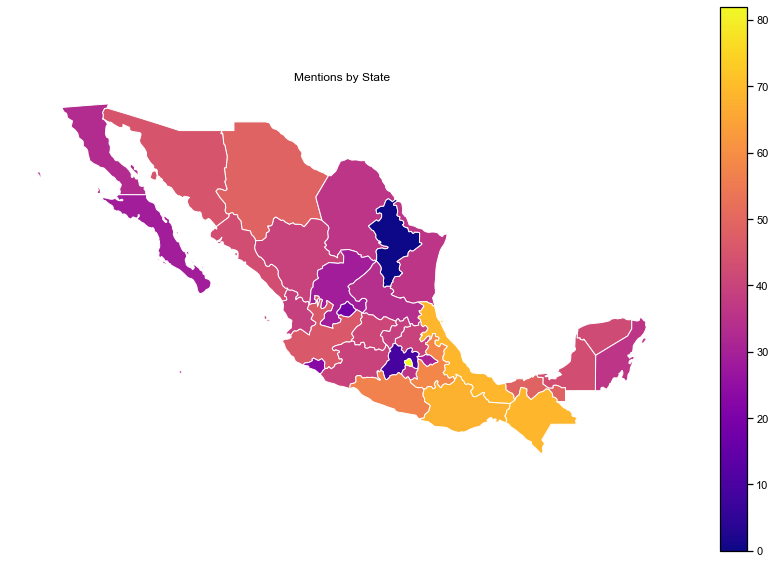

In [35]:
plot_map(df_e)

#### Generating Bar Plot with Sentiment Scores of Each Sentence

In [36]:
df_sentences= pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Capstone Project\Main Capstone Project Two\sentences.csv")

In [37]:
df_sentences.head()

,text,score
0,POLÍTICA Y GOBIERNO La Cuarta TransformaciŠn h...,-1
1,"Sin duda, también ha requerido una intensa act...",-1
2,"A la par, se ha garantizado la gobernabilidad ...",0
3,Algunas de ellas incluyen el privilegiar la de...,1
4,"ERRADICAR LA CORRUPCIÓN, EL DISPENDIO Y LA FRI...",-1


In [78]:
def plot_sentiment_analysis(df):
   
    df = df[(df["score"] <= 10) & (df["score"] >= -10)]

# Make bars with a score below zero the color yellow and bars with a score above zero blue.
    colors = np.array([(0.811, 0.913, 0.145)]*len(df["score"]))
    colors[df["score"] >= 0] = (0.529, 0.870, 0.972)

    yticks_labels = [str(i) for i in range(-12, 12, 2)]
    plt.yticks(np.arange(-12, 12, 2), yticks_labels)

    ax = plt.bar(df.index, df["score"], color=colors, linewidth=0)
    plt.xlabel("Sentence Number")
    plt.ylabel("Score")
    plt.title("Sentiment Analysis")
    #ax.set_facecolor('black')

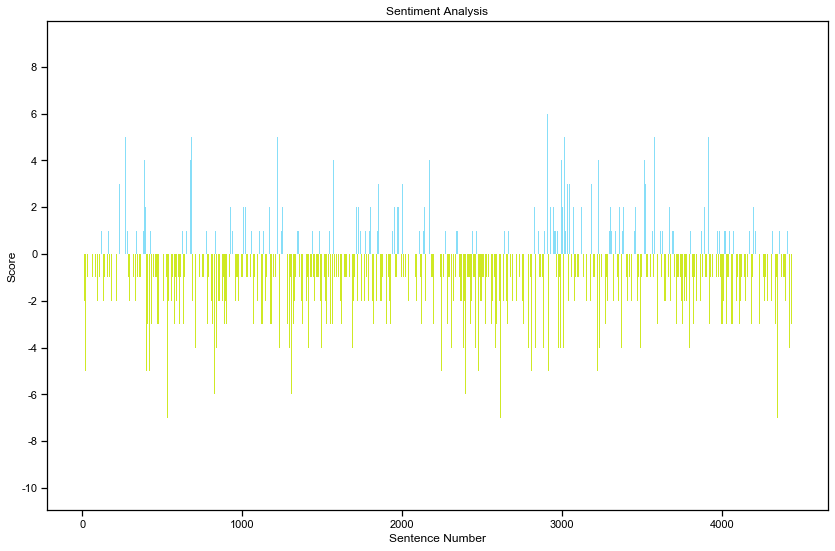

In [79]:
plot_sentiment_analysis(df_sentences)

#### Generating Donut Plot of the Sentiment Analysis

In [74]:
def plot_donut(df):

    labels = ["Positive", "Negative", "Neutral"]

    positive = len(df[df["score"] > 0])
    negative = len(df[df["score"] < 0])
    neutral = len(df[df["score"] == 0])

    values = [positive, negative, neutral]
    colors = ["green", "red", "gray"]
    explode = (0, 0, 0)  # Explode a slice if required

    plt.rcParams["font.size"] = 18
    plt.rcParams["legend.fontsize"] = 20

    plt.pie(values, explode=explode, labels=None,
            colors=colors, autopct='%1.1f%%', shadow=False)

# Drawing a circle in the Pie chart to make it a donut chart:
    centre_circle = plt.Circle((0, 0), 0.75, 
                    color="white", fc="white", linewidth=0)

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis("equal")
    plt.legend(labels)


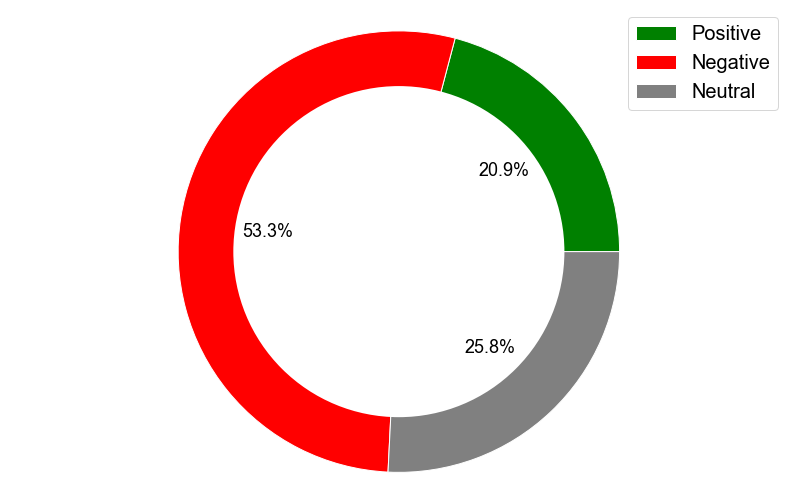

In [75]:
plot_donut(df_sentences)

# Logistic Regression Classifier

What I do in the following section is develop a classification model that looks at the text and predicts whether a sentence is positive or negative. Since I already conducted a sentimental analysis and the data frame `df_sentences` already includes whether a sentence is positive or negative, I can use those answers to train and test my model. The goal here is to produce an accurate model that we could then use to process new government annual reports and quickly determine whether they were positive or negative.

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [52]:
import string
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish

In [49]:
df_sentences.head()

,text,score
0,POLÍTICA Y GOBIERNO La Cuarta TransformaciŠn h...,-1
1,"Sin duda, también ha requerido una intensa act...",-1
2,"A la par, se ha garantizado la gobernabilidad ...",0
3,Algunas de ellas incluyen el privilegiar la de...,1
4,"ERRADICAR LA CORRUPCIÓN, EL DISPENDIO Y LA FRI...",-1


In [53]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('es_core_news_md')
stop_words = spacy.lang.es.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = Spanish()

In [39]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens



In [40]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [41]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [43]:
from sklearn.model_selection import train_test_split

X = df_sentences['text'] # the features I want to analyze
ylabels = df_sentences['score'] # the labels, or answers, I want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [45]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [54]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression [_logistic.py:939]


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x000001D7278F3160>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x000001D711DCF950>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

The following code block is used to check how accurate and precise the model is as well as the recall. <br> 

* Accuracy refers to the percentage of the total predictions the model makes that are completely correct.
* Precision describes the ratio of true positives to true positives plus false positives in predictions.
* Recall describes the ratio of true positives to true positives plus false negatives in predictions.

In [55]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.28582145536384096


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].